# Facial Key-Points Detection

### Importing Libraires

In [1]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

from IPython.display import display
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# load the data
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')

In [3]:
facialpoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [5]:
# Sample image
facialpoints_df['Image'][1]

'219 215 204 196 204 211 212 200 180 168 178 196 194 196 203 209 199 192 197 201 207 215 199 190 182 180 183 190 190 176 175 175 170 158 162 170 150 133 133 128 121 115 115 114 112 114 113 112 120 127 123 118 112 109 112 110 107 106 104 104 100 98 105 122 135 143 152 135 114 104 81 74 87 107 98 82 84 79 70 69 62 62 79 94 97 100 98 93 100 100 97 96 93 92 88 84 222 219 220 211 207 199 185 178 171 175 196 199 199 200 201 205 202 200 204 206 211 219 204 192 188 185 185 193 189 180 177 178 173 158 159 162 145 133 133 129 122 118 116 115 114 115 115 118 127 132 127 120 116 119 118 114 114 113 110 108 105 104 110 130 140 149 152 128 106 106 91 78 90 107 101 84 90 93 79 75 73 59 58 74 94 102 100 99 97 90 94 96 95 92 88 86 231 224 212 197 191 186 176 170 172 190 201 199 200 203 204 210 215 211 210 213 213 217 210 192 188 188 189 194 189 183 181 183 175 158 158 158 142 132 133 131 125 120 121 120 116 115 116 122 135 137 129 122 121 125 121 119 120 118 117 112 112 109 116 136 149 156 149 126 109 

In [6]:
# Since values for the image is given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [7]:
# Let's obtain the shape of the resized image
facialpoints_df['Image'][1].shape

(96, 96)

In [8]:
# Let's confirm that there are no null values 
facialpoints_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [9]:
facialpoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


### Data Visualization

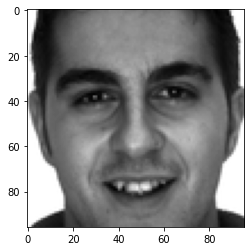

In [10]:
# Plot a random image from the dataset along with facial keypoints. 

i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray');

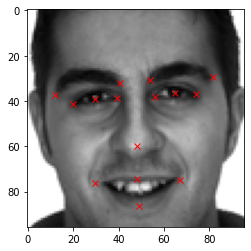

In [11]:
# Plot image with key points included
plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


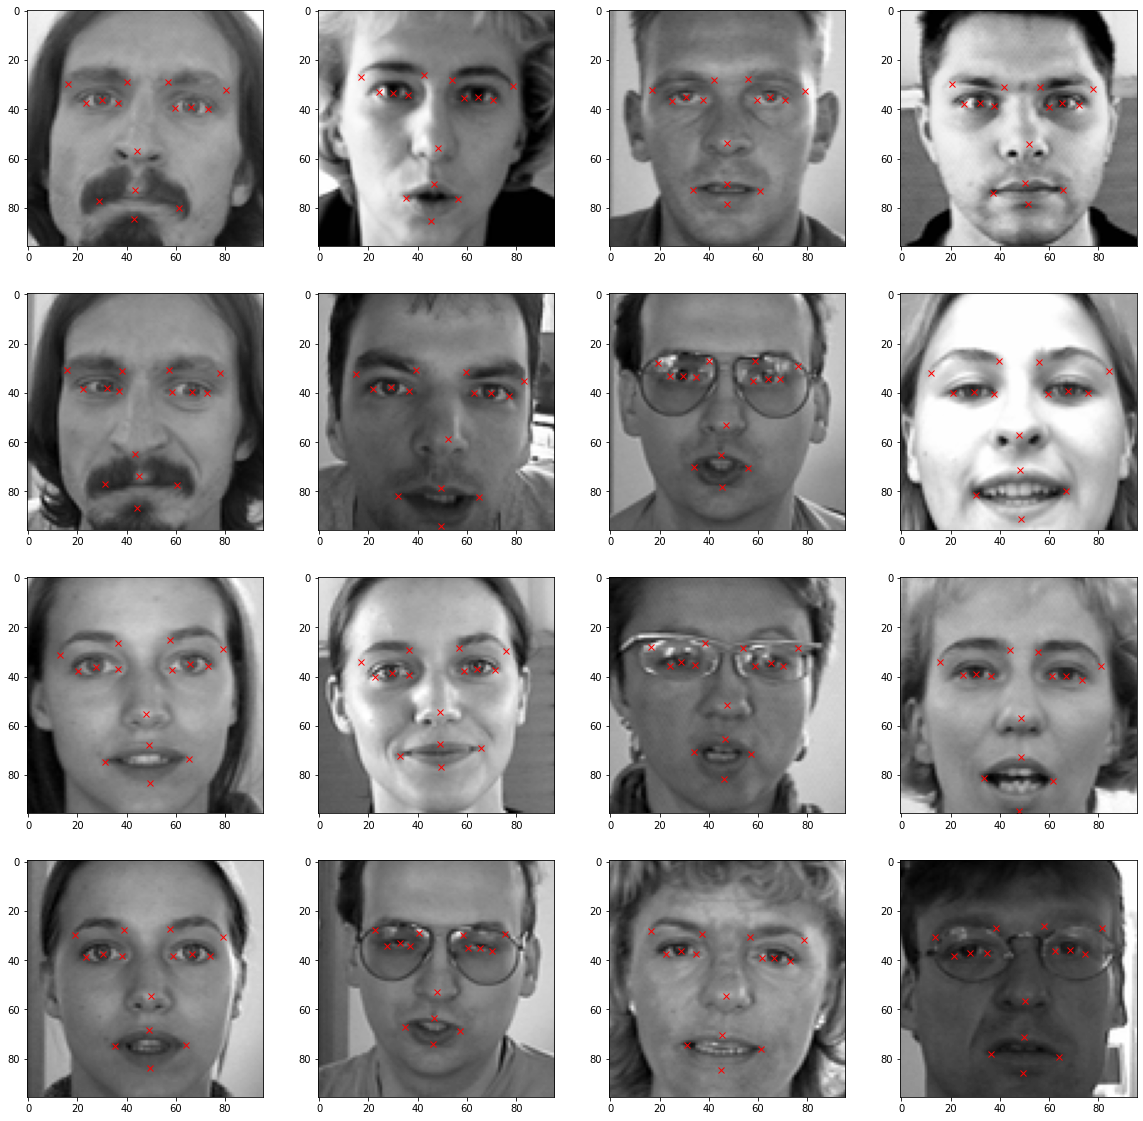

In [12]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')
    

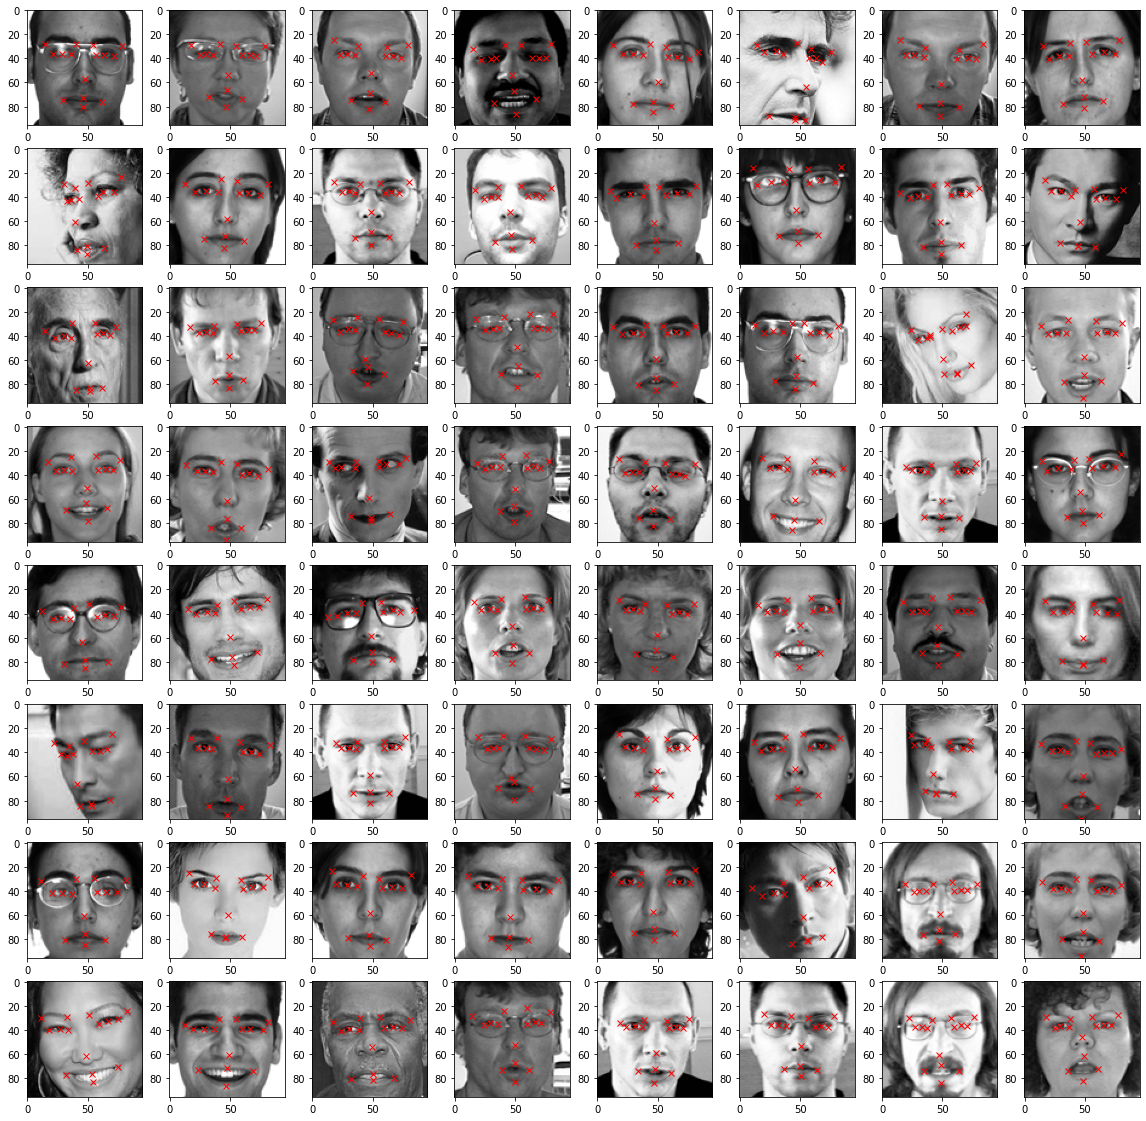

In [13]:
# Print a grid of images

fig = plt.figure(figsize=(20, 20))

for i in range(64):
    img = np.random.randint(1, len(facialpoints_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][img], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[img][j-1], facialpoints_df.loc[img][j], 'rx')

### Data Augmentation

In [14]:
# Create a new copy of the dataframe

import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [15]:
# obtain the header of the DataFrame (names of columns) 

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [16]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

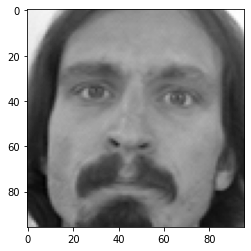

In [17]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray');

In [18]:
# flip the image column horizontally 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

In [19]:
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

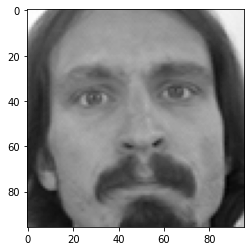

In [20]:
# Plot the flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray');

In [21]:
# Correct the coordinates of the key features by subtracting initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

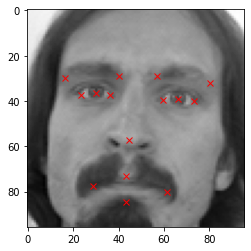

In [22]:
# View the Original image
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

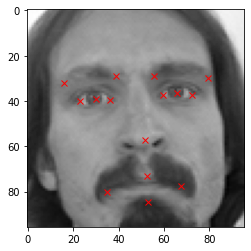

In [23]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [24]:
# Concatenate the original dataframe with the augmented dataframe

facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [25]:
facialpoints_df_augmented.shape

(4280, 31)

In [26]:
# Randomly increasing images brightness and clip the value between 0 and 255

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

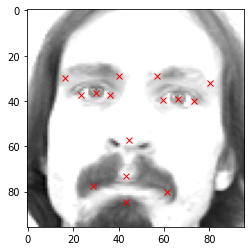

In [27]:
# Image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

### Perform Data Preprocessing and Normalization

In [29]:
# Obtain the value of 'Images' and normalize it

img = facialpoints_df_augmented[:, 30]
img = img/255.

# Create an empty array of shape (10700, 96, 96, 1) to train the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array 
for i in range(len(img)):
  # expand dimension from (96,96) to (96,96,1)
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)

In [30]:
X.shape

(6420, 96, 96, 1)

In [31]:
# Obtain the values of key face points coordinates
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [32]:
# Split the data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

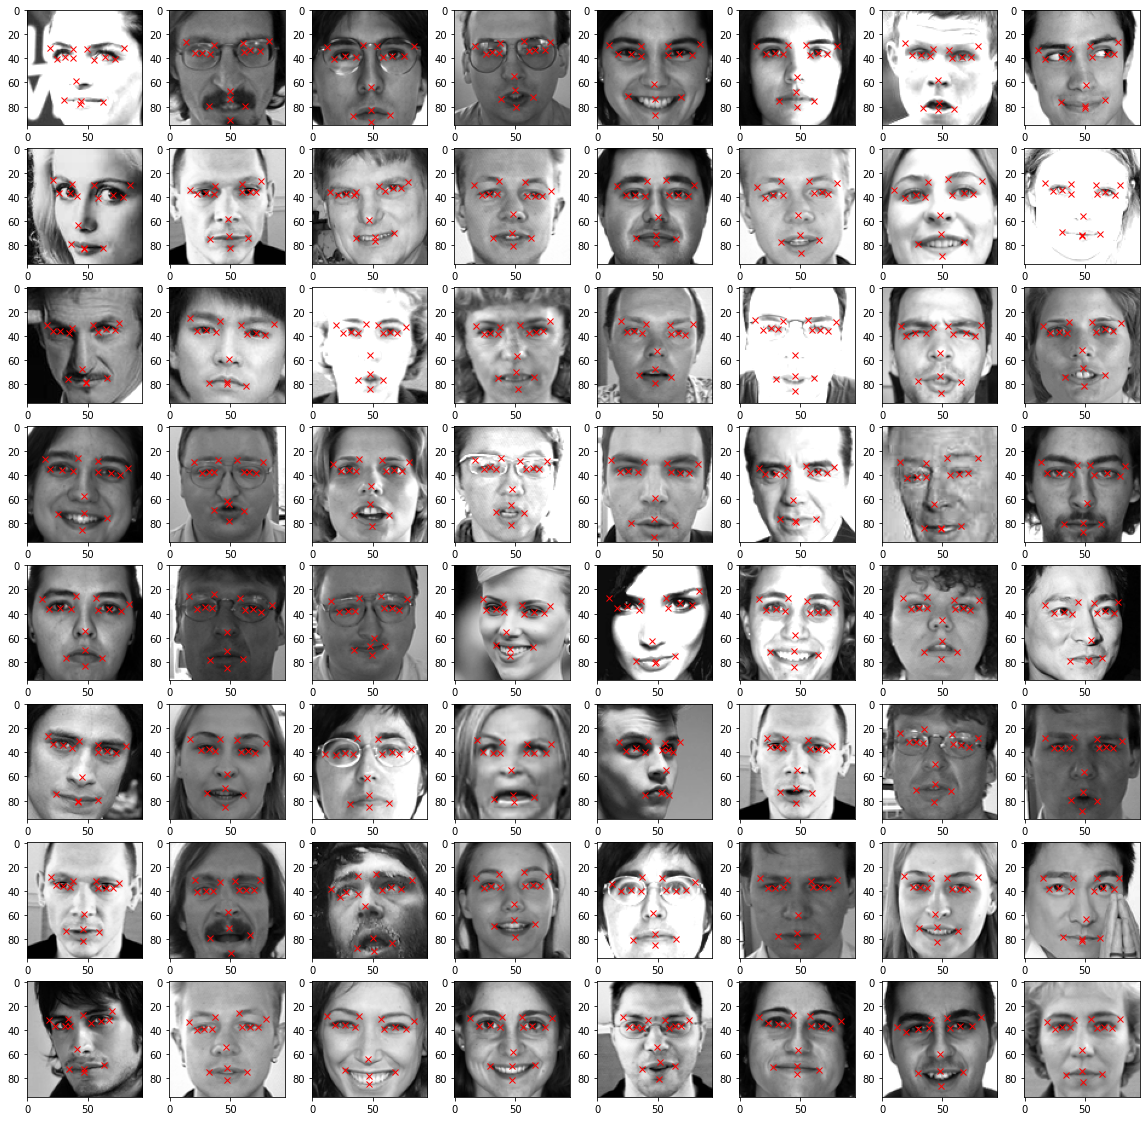

In [34]:
# Plot augmented data
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(X_train[i].reshape(96,96), cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(y_train[i][j-1], y_train[i][j], 'rx')

### Building a Resnet Model

In [35]:
def res_block(X, filters, stage):
    
    # CONVOLUTIONAL BLOCK
    X_copy = X
    f1 , f2, f3 = filters

    # Main Path
    X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

    # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    # Add data from main and short paths
    X = Add()([X,X_copy])
    X = Activation('relu')(X)



    # IDENTITY BLOCK 1
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    # Add both paths together ("identity")
    X = Add()([X,X_copy])
    X = Activation('relu')(X)



    # IDENTITY BLOCK 2
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    # Add both paths together ("identity")
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [43]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filters= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filters= [128,128,512], stage= 3)

# X = res_block(X, filters= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layers
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 102, 102, 1)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

### Train the Model

In [47]:
adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [48]:
# save the best model with least validation loss
CP = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)
ES = EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05, callbacks=[CP, ES])

Epoch 1/100
22/22 [==============================] - 60s 3s/step - loss: 199.9074 - accuracy: 0.6109 - val_loss: 914.6306 - val_accuracy: 0.6678

Epoch 00001: val_loss improved from inf to 914.63062, saving model to weights.hdf5


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
22/22 [==============================] - 80s 4s/step - loss: 79.4517 - accuracy: 0.6345 - val_loss: 750.0397 - val_accuracy: 0.6678

Epoch 00002: val_loss improved from 914.63062 to 750.03973, saving model to weights.hdf5
Epoch 3/100
22/22 [==============================] - 67s 3s/step - loss: 57.2855 - accuracy: 0.6262 - val_loss: 580.7372 - val_accuracy: 0.6678

Epoch 00003: val_loss improved from 750.03973 to 580.73718, saving model to weights.hdf5
Epoch 4/100
22/22 [==============================] - 68s 3s/step - loss: 47.7454 - accuracy: 0.6187 - val_loss: 479.4366 - val_accuracy: 0.6678

Epoch 00004: val_loss improved from 580.73718 to 479.43665, saving model to weights.hdf5
Epoch 5/100
22/22 [==============================] - 70s 3s/step - loss: 41.3380 - accuracy: 0.6289 - val_loss: 378.9793 - val_accuracy: 0.6678

Epoch 00005: val_loss improved from 479.43665 to 378.97928, saving model to weights.hdf5
Epoch 6/100
22/22 [==============================] - 74s 3s/step

In [54]:
# Save trained model
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

### Assess Model Performance

In [60]:
# instead of training from scratch, you can load trained model weights
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [ ]:
# Evaluate trained model
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

In [ ]:
# Make prediction using the testing dataset
df_predict = model.predict(X_test)

In [ ]:
# Print the rmse loss values

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

In [ ]:
# Convert the predicted values into a dataframe

df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

In [ ]:
# Plot the test images and their predicted keypoints

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')